In [ ]:
# FCN Network - 입력값이 거쳐가는 순서대로 사용자 정의 함수 기술하기
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

# sigmoid 미분 : (1-y)y  * y = sigmoid(x)
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

    
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

# 지수함수는 아주 쉽게 큰 값을 갖는다.
# 나눗셈을 하면 불안정한 값을 갖는다.(오버플로우)
# 오버플로우가 발생하면 nan이 출력됨
    x = x - np.max(x) # overflow(NAN:Not A Number) 대책 - 입력값 중 최댓값을 추출해 overflow 방지
    return np.exp(x) / np.sum(np.exp(x))



def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size



In [ ]:
# softmax로 확률값을 추출하여 오차 함수를 구한 후, 수치미분
# 실제로는 수치미분은 속도가 느려 사용하지 않는다
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()
    return grad

In [ ]:
# coding : utf-8
class TwoLayerNet:
    """
    params : 신경망의 매개변수를 보관하는 딕셔너리 변수.
    params['W1']은 1번째 층의 가중치, params['b1']은 1번째 층의 편향.
    params['W2']은 2번째 층의 가중치, params['b2']은 2번째 층의 편향.
    grad : 기울기를 보관하는 딕셔너리 변수(numerical_gradient()의 반환값)
    grads['W1']은 1번째 층의 가중치의 기울기, grads['b1']은 1번째 층의 편향의 기울기.
    grads['W2']은 2번째 층의 가중치의 기울기, grads['b2']은 2번째 층의 편향의 기울기.
    """
    # 초기화를 수행한다.(input_size = 784,output_size = 10 : 10개의 확률값 중 최댓값 하나를 채택)
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # 가중치 초기화(인스턴스 생성되면 가중치를 random하게 초기화)
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size) # w는 random값, bias는 0으로 초기화
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 예측(추론)을 수행한다.
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1   # layer 0 : matrix 곱 + bias
        z1 = sigmoid(a1)
        #sigmoid 활성화함수
        a2 = np.dot(z1, W2) + b2  # layer 0의 출력값을 layer 1의 입력값으로 사용
        y = softmax(a2)     # 출력단이므로 softmax 함수 사용 -> 그 결과 prediction 값이 나옴
       
        # softmax y의 확률값 : 예측치를 return 
        return y

    # 손실 함수의 값을 구한다.
    # x : 입력데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        #결과의 확률값과 원핫인코딩된 값을 비교
        return cross_entropy_error(y, t)

    # 정확도를 구한다.
    def accuracy(self, x, t):
        y = self.predict(x)  # x 입력, y 예측치, t 정답
        y = np.argmax(y, axis=1)  
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 가중치 매개변수의 기울기를 구한다.
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}  # 784 * 50 개의 w값이 있음 : 하나씩 편미분
        grads['W1'] = numerical_gradient(loss_W, self.params['W1']) # 해당되는 layer의 parameter로 오차(loss)를 편미분
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads  # dictionary 형태로 구성되어 있음
    '''   '''
    def gradient(self, x, t):  # 수치미분 X, 공식에 의한 미분 O
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward : 아래처럼 직접 서술하지 않고, predict 함수를 호출해도 됨
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward : back propagation(편미분 대신에 graphical하게 연산)으로 계속해서 공식에 의한 미분
        dy = (y - t) / batch_num  # softmax 미분은 y-t로 공식처럼 굳어져있음
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads  # 미분한 값을 넘긴다 for parameter update

In [ ]:
import tensorflow as tf
import numpy as np

(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()
t_train=tf.keras.utils.to_categorical(t_train) # keras의 API : 0~1 사이의 값으로 변환해줌
t_test=tf.keras.utils.to_categorical(t_test)
x_train=x_train.reshape(60000,-1)
x_test=x_test.reshape(10000,-1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) # weight 값을 random하게 초기화하고, network라는 인스턴스를 할당받는다

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


train acc, test acc | 0.8988833333333334, 0.9006
train acc, test acc | 0.9014833333333333, 0.9006
train acc, test acc | 0.9030666666666667, 0.9045
train acc, test acc | 0.9017666666666667, 0.9045
train acc, test acc | 0.9032166666666667, 0.9061
train acc, test acc | 0.90065, 0.9022
train acc, test acc | 0.90745, 0.909
train acc, test acc | 0.90635, 0.9065
train acc, test acc | 0.9075833333333333, 0.9084
train acc, test acc | 0.9006333333333333, 0.903
train acc, test acc | 0.8965666666666666, 0.9009
train acc, test acc | 0.9005833333333333, 0.9026
train acc, test acc | 0.9007166666666667, 0.8969
train acc, test acc | 0.9069, 0.9071
train acc, test acc | 0.90595, 0.9114
train acc, test acc | 0.91095, 0.9113
train acc, test acc | 0.9113, 0.9129


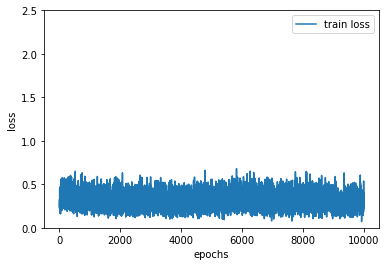




훈련데이터와 시험 데이터에 대한 정확도 추이


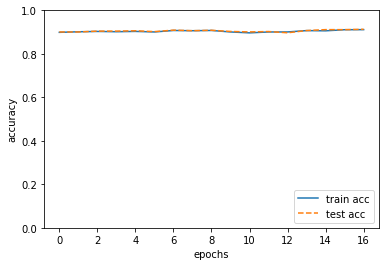

In [ ]:
import matplotlib.pyplot as plt

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 수치 미분이 아닌 공식에 의한 미분 계산 : prediction -> softmax -> loss함수 -> 미분
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))



# loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()                   # 위
#plt.legend(loc='lower right') # 아래
plt.show()




print("\n\n\n훈련데이터와 시험 데이터에 대한 정확도 추이")
# accuracy 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()  #acc 값 보여주기 : train과 test accuracy의 차이가 없기 때문에 overfit되지 않았음